In [1]:
import os.path as osp

import pyro
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

from model.BayesExplainer import BayesExplainer
from model.samplers.BetaBernoulliSampler import BetaBernoulliSampler
from model.samplers.NFSampler import NFSampler
from model.samplers.SpikeSlabSampler import SpikeSlabSampler

from tqdm.autonotebook import tqdm

dataset = 'Cora'
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear = torch.nn.Linear(16, dataset.num_features)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

pbar = tqdm(range(1000))
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pbar.set_description("Loss -> %.5f" % loss.item())
model.eval()

/users/spate116/ml/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Net(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=1433, bias=True)
)

Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 322.45it/s]


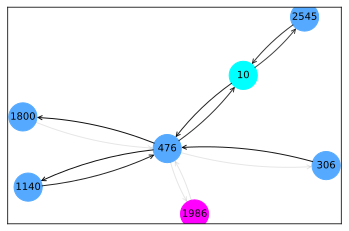

In [2]:
explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

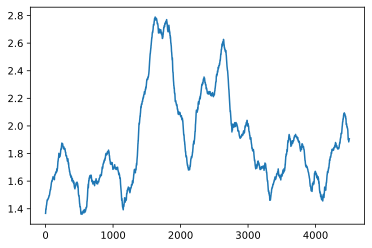

In [3]:
node_idx = 10
k = 2
sampler = BetaBernoulliSampler("cora_beta_bernoulli", 1.0, 3.0)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=5000, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

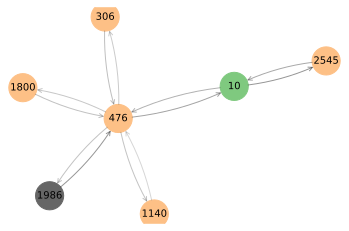

In [4]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [5]:
edge_mask

tensor([0.3025, 0.4122, 0.2518, 0.3555, 0.2040, 0.2359, 0.2210, 0.2387, 0.1640,
        0.2422, 0.4107, 0.3385], grad_fn=<DivBackward0>)

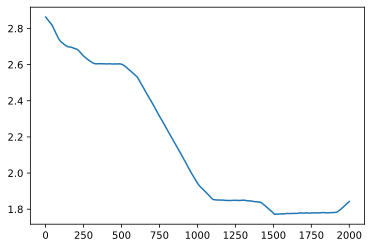

In [6]:
node_idx = 10
k = 2
splines = 8
sampler = NFSampler("cora_nf_sampler", explainer.N, splines, True, 5, 1, device)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=2500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

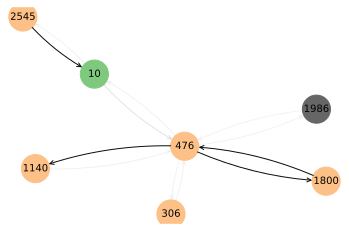

In [7]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [8]:
edge_mask

tensor([0.1090, 0.0519, 0.0517, 0.0549, 0.0531, 0.9452, 0.9514, 0.0540, 0.0553,
        0.9508, 0.0495, 0.9510], grad_fn=<MeanBackward1>)

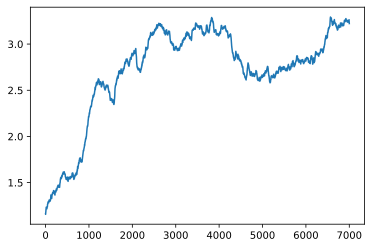

In [9]:
node_idx = 10
k = 2
sampler = SpikeSlabSampler("cora_spike_slab", 0.25, 1, 5, 10, 1)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=7500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

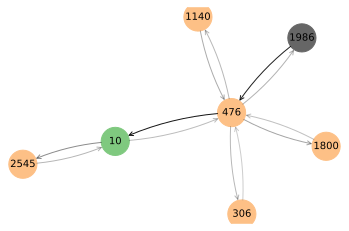

In [10]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [11]:
edge_mask

tensor([0.2644, 0.4530, 0.2007, 0.9129, 0.2785, 0.2776, 0.3528, 0.3023, 0.3254,
        0.2497, 0.8704, 0.2876], grad_fn=<AddBackward0>)